# Embedding workflow using DINOv2

This notebook focuses on the **Feature Extraction** pipeline. 

We utilize the fine-tuned model **ViTD2PC24All** ([DINOv2](https://dinov2.metademolab.com/)) to extract high-dimensional embeddings from the single-label train images and multi-label test images.

We'll **visualize**, **tile**, and **process** these embeddings to support patch-wise multi-label inference using PyTorch and Faiss.

![diagram](../images/pytorch-webinar-diagram.png)

In [1]:
# !uv pip list | grep pydantic
# !uv pip install meerkat-ml
# !which pip

# !uv pip install pyspark -v

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# !uv pip install meerkat-ml
# !uv pip install "pydantic<1.10.17"

# !java -version

# !sudo apt-get update
# !sudo apt-get install openjdk-8-jdk
# !sudo apt install default-jdk

In [2]:
# from plantclef.spark_utils import get_spark
# from pyspark.sql.functions import element_at, regexp_replace, split

# spark = get_spark()
# import os
# from pathlib import Path


# test_parquet_output_dir = "/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test"
# os.makedirs(test_parquet_output_dir, exist_ok=True)

# root = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025"
# test_image_dir = (
#     root + "/competition-metadata/PlantCLEF2025_test_images/PlantCLEF2025_test_images"
# )


# root_dir = Path(test_image_dir)
# output_dir = Path(test_parquet_output_dir)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_sdk/helpers.py:48: UserWarning: A newer version of lightning-sdk is available (0.2.14). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  warnings.warn(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/02 04:21:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/02 04:21:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## Construct a pyspark dataframe for the test images + save it to disk as a parquet file

In [15]:
# image_df = (
#     spark.read.format("binaryFile")
#     .option("pathGlobFilter", "*.jpg")
#     .option("recursiveFileLookup", "true")
#     .load(root_dir.as_posix())
# )


# to_remove = "file:" + str(root_dir.parents[0])

# # Remove "file:{base_dir.parents[0]" from path column
# image_df = image_df.withColumn("path", regexp_replace("path", to_remove, ""))

# split_path = split(image_df["path"], "/")
# image_df = image_df.withColumn("file_name", element_at(split_path, -1))

# image_df = image_df.select(
#     "path",
#     "file_name",
#     image_df["content"].alias("data"),
# )
# image_df.write.mode("overwrite").parquet(str(output_dir))

## Take a small sample of rows from the pyspark dataframe and visualize them with pyplot

In [21]:
sample_df = []  # image_df.limit(16).toPandas()
# print(f"sample_df.shape = {sample_df.shape}")
# sample_df.info()

sample_df.shape = (16, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       16 non-null     object
 1   file_name  16 non-null     object
 2   data       16 non-null     object
dtypes: object(3)
memory usage: 512.0+ bytes


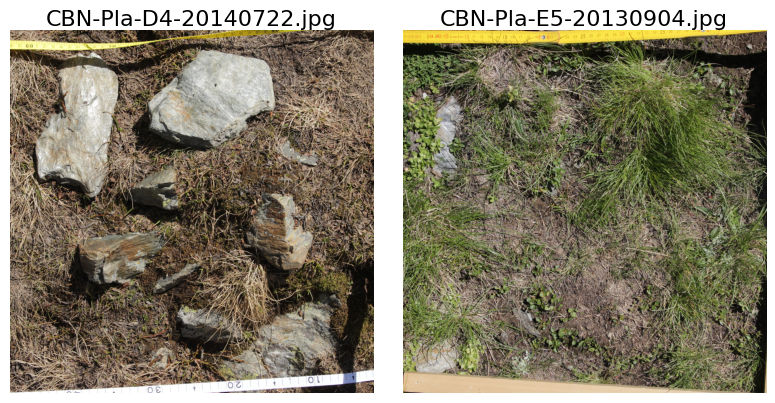

In [23]:
from plantclef.plotting import plot_images_from_binary

# plot_images_from_binary(
#     sample_df.head(2),
#     data_col="data",
#     label_col="file_name",
#     grid_size=(1, 2),
#     crop_square=True,
#     figsize=(8, 4),
# )

## Now to load the parquet file from disk and visualize the images

In [ ]:
# !uv pip install "dask[complete]"
# !uv pip install dask-image graphviz

In [2]:
output_dir = "/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test"

In [3]:
# import torchdata

import pyarrow.parquet as pq

parquet_path = output_dir

table = pq.read_table(parquet_path)

In [8]:
import numpy as np
from plantclef.serde import deserialize_image

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_sdk/helpers.py:48: UserWarning: A newer version of lightning-sdk is available (0.2.14). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  warnings.warn(


In [9]:
image_col = "data"

idx = 0

batch = table.slice(idx, 4).to_pandas()

row = batch.iloc[idx]
img_data = row[image_col]
# preprocess_img = lambda x: np.asarray(deserialize_image(x))
# img = preprocess_img(img_data)

# batch.num_rows

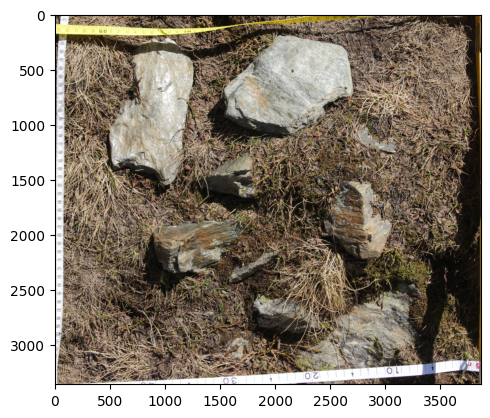

In [11]:
# plt.imshow(img)

In [12]:
import pandas as pd

pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [4]:
import dask.dataframe as dd


df = dd.read_parquet(
    output_dir,
    engine="pyarrow",
    # columns=["path", "file_name", "data"]
)

In [18]:
#  preprocess_img = lambda x: np.asarray(deserialize_image(x))

img_col = df["data"].map(deserialize_image, meta={"image": np.float32})  # .compute()

In [28]:
img_col.size.compute()

2105

In [24]:
img_col.head(10)  # .values[0]

0    <PIL.Image.Image image mode=RGB size=3867x3355...
1    <PIL.Image.Image image mode=RGB size=3528x3204...
2    <PIL.Image.Image image mode=RGB size=3620x3292...
3    <PIL.Image.Image image mode=RGB size=3648x3256...
4    <PIL.Image.Image image mode=RGB size=3340x3236...
5    <PIL.Image.Image image mode=RGB size=3223x3437...
6    <PIL.Image.Image image mode=RGB size=3496x3024...
7    <PIL.Image.Image image mode=RGB size=2975x3365...
8    <PIL.Image.Image image mode=RGB size=3632x3420...
9    <PIL.Image.Image image mode=RGB size=3616x2960...
Name: data, dtype: object

In [37]:
df.index.head(5)

Index([0, 1, 2, 3, 4], dtype='int64')

In [45]:
df.shape[1]

3

In [ ]:
a = df.loc[6]  # img_col.head(10)
# dask.visualize(a)
# a.compute()

: 

In [11]:
# df.partitions[0]
len(df.divisions)

123

In [ ]:
plot_images_from_binary(
    sample_df.head(2),
    data_col="data",
    label_col="file_name",
    grid_size=(1, 2),
    crop_square=True,
    figsize=(8, 4),
)

# Misc below

In [ ]:
# image_df.show()
# image_df.printSchema()
# image_df.tail(4)

In [ ]:
import torch
from plantclef.config import get_device

print(f"PyTorch Version: {torch.__version__}")
device = get_device()
print(f"Using device: {device}")

In [ ]:
import pandas as pd
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path().resolve().parents[0]
print(root)
! date

In [1]:
import meerkat as mk

In [ ]:
from plantclef.datasets.utils import collect_image_filepaths
from pathlib import Path
import os


test_parquet_output_dir = "/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test"
os.makedirs(test_parquet_output_dir, exist_ok=True)

root = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025"
test_image_dir = (
    root + "/competition-metadata/PlantCLEF2025_test_images/PlantCLEF2025_test_images"
)


test_image_filepaths = collect_image_filepaths(test_image_dir)

print(f"Number of test images: {len(test_image_filepaths)}")

In [ ]:
test_df = mk.DataFrame(
    {
        "image_name": [Path(f).name for f in test_image_filepaths],
        "image_filepaths": test_image_filepaths,
    }
)
# print(f"Serializing {len(test_df)} images")


# test_df["data"] = mk.image(test_df["image_filepaths"])
# test_df.head(1)

In [ ]:
dir(test_df.data)

In [ ]:
dir(test_df["data"])

In [25]:
# test_df_path = Path(test_parquet_output_dir, "test.parquet")
# test_df.to_parquet(test_df_path)

test_df_path = Path(test_parquet_output_dir, "test.mk")
test_df.write(test_df_path)

In [ ]:
check_df = mk.read(str(test_df_path))
check_df.head(1)

In [ ]:
# read train/test data
train_df = []  # pd.read_parquet(train_path)
test_df = []  # pd.read_parquet(test_path)

# display data
# print(f"Train DF shape: {train_df.shape}")
print(f"Test DF shape: {test_df.shape}")
# display(train_df.head(3))
display(test_df.head(3))

### Extracting embeddings from single-label training images

We extract embeddings from a small subset of training images to validate our pipeline.  
We don't perform tiling on the train images (we use the full image) and extract 768-dimensional ViT embeddings.

In [ ]:
# limit to 2 samples for testing
limit_train_df = train_df  # .head(2)
print(f"Limit DF shape: {limit_train_df.shape}")

In [ ]:
from plantclef.embed.workflow import torch_pipeline

# extract embeddings
embeddings, logits = torch_pipeline(
    limit_train_df,
    batch_size=2,
    use_grid=False,
    cpu_count=1,
)

In [ ]:
# embeddings shape
embeddings.shape

In [ ]:
# first embedding
embeddings[0][0][:100]  # showing first 100 values out of 768

In [ ]:
# create embeddings dataframe
cols = ["image_name", "data", "species", "species_id"]
embeddings_df = limit_train_df[cols].copy()
embeddings_df["embeddings"] = embeddings.tolist()
embeddings_df.head(2)

In [ ]:
from plantclef.plotting import plot_images_from_binary

plot_images_from_binary(
    embeddings_df,
    data_col="data",
    label_col="species",
    grid_size=(1, 2),
    crop_square=True,
    figsize=(8, 4),
)

In [ ]:
from plantclef.plotting import plot_embeddings

plot_embeddings(
    embeddings_df,
    data_col="embeddings",
    label_col="species",
    grid_size=(1, 2),
    figsize=(8, 4),
)

### Embedding test images with tiling (3x3)


Since the test images are high-resolution and contain multiple plant species, we split them into a 3x3 grid of tiles.
- We **extract embeddings** and **top-*K* logits** from each tile using the ViT model.  
- This **patch-wise representation** is critical for enabling multi-label classification.

In [ ]:
# set params
USE_GRID = True
GRID_SIZE = 3  # 3x3 grid of tiles
CPU_COUNT = 1  # custom cpu_count
TOP_K = 5  # top-K logits for each tile

# select images from test set
image_names = ["CBN-Pyr-03-20230706.jpg", "CBN-can-E6-20230706.jpg"]
test_image_df = test_df[test_df["image_name"].isin(image_names)]

# get embeddings and logits
embeddings, logits = torch_pipeline(
    test_image_df,
    batch_size=2,
    use_grid=USE_GRID,
    grid_size=GRID_SIZE,
    cpu_count=CPU_COUNT,
    top_k=TOP_K,
)

In [ ]:
# embeddings shape
embeddings.shape  # (2, 9, 768)

In [14]:
# create embeddings dataframe
def explode_embeddings_logits(
    df: pd.DataFrame,
    embeddings: torch.Tensor,
    logits: list,
    cols: list = ["image_name", "data"],
) -> pd.DataFrame:
    # create dataframe
    pred_df = df[cols].copy()
    pred_df["embeddings"] = embeddings.cpu().tolist()
    pred_df["logits"] = logits
    # explode embeddings
    explode_df = pred_df.explode(["embeddings", "logits"], ignore_index=True)
    # assign tile number for each image
    explode_df["tile"] = explode_df.groupby("image_name").cumcount()
    return explode_df

In [ ]:
explode_df = explode_embeddings_logits(test_image_df, embeddings, logits)
explode_df.head(9)

In [ ]:
from plantclef.plotting import plot_image_tiles

# show image tiles
plot_image_tiles(
    explode_df,
    data_col="data",
    grid_size=3,
)

In [ ]:
from plantclef.plotting import plot_embed_tiles

plot_embed_tiles(
    explode_df,
    data_col="embeddings",
    grid_size=3,
    figsize=(15, 8),
)

In [ ]:
# plot grid embeddings
plot_embeddings(
    explode_df,
    data_col="embeddings",
    label_col="tile",
    grid_size=(3, 3),
    figsize=(8, 8),
)

### Analyzing classifier logits per tile

For each tile, we look at the **top predicted species** and associated confidence scores (`logits`).  
This helps interpret how confident the model is in identifying species in each patch.

In [ ]:
print(f"Length logits: {len(logits)}")

In [ ]:
# display logits of first tile
explode_df["logits"].iloc[0]

In [ ]:
# display logits for each tile
for i in range(9):
    logits = explode_df["logits"].iloc[i]
    logits_formatted = {k: round(v, 3) for k, v in logits.items()}
    print(f"Tile {i+1}: {logits_formatted}")

### Embedding the entire test set with tiling

We scale up our embedding pipeline to process the full test dataset using **3x3 tiling**.  
This prepares the data for the downstream tasks of efficient **nearest neighbor search** and **multi-label prediction** at the tile level.

In [ ]:
import os

cpu_count = os.cpu_count()
print(f"CPU count: {cpu_count}")

In [ ]:
# params
USE_GRID = True
GRID_SIZE = 3  # 3x3 grid of tiles
CPU_COUNT = 1  # custom cpu_count
TOP_K = 5  # top-K logits for each tile

# get embeddings and logits
test_embeddings, test_logits = torch_pipeline(
    test_df,
    batch_size=10,  # 10 imamges per batch
    use_grid=USE_GRID,
    grid_size=GRID_SIZE,
    cpu_count=CPU_COUNT,
    top_k=TOP_K,
)

In [ ]:
print(test_embeddings.shape)
print(len(test_logits))

In [25]:
# explode full embeddings and logits
test_explode_df = explode_embeddings_logits(
    test_df,
    test_embeddings,
    test_logits,
)

In [ ]:
print(test_explode_df.shape)
test_explode_df.head(9)

In [ ]:
plot_embed_tiles(
    test_explode_df,
    data_col="embeddings",
    grid_size=3,
)

### Saving test embeddings and logits to Parquet

We serialize the full test embeddings into partitioned Parquet files for later use in inference pipelines.  
The logits are stored as JSON strings for flexibility.

In [ ]:
import json
import shutil
import numpy as np


def write_embeddings_to_parquet(
    df: pd.DataFrame,
    folder_name: str,
    num_partitions: int = 20,
):
    # path to data
    root = Path().resolve().parents[0]
    data_path = f"{root}/data/embeddings"
    output_path = f"{data_path}/{folder_name}"

    # remove existing data if it exists to avoid duplication
    if Path(output_path).exists():
        shutil.rmtree(output_path, ignore_errors=True)

    # convert logits to json strings
    df["logits"] = df["logits"].apply(json.dumps)

    # assign partition numbers (0 to num_partitions-1)
    df_size = len(df)
    df["partition"] = np.repeat(
        np.arange(num_partitions), np.ceil(df_size / num_partitions)
    )[:df_size]

    # write to parquet using the new partition column
    df.to_parquet(output_path, partition_cols=["partition"], index=False)

    print(
        f"Embedding dataset written to: {output_path} with {num_partitions} partitions."
    )


# write data
folder_name = f"test_grid_{GRID_SIZE}x{GRID_SIZE}_embeddings"
write_embeddings_to_parquet(test_explode_df, folder_name, num_partitions=10)

## Embedding the full training set (no tiling)

We repeat the embedding process on the **full training dataset**, this time *without tiling*.  
This enables us to use the embeddings directly or as a **transfer learning** approach in a Faiss-based nearest neighbor retrieval system.

In [ ]:
# params
USE_GRID = False
CPU_COUNT = 1  # custom cpu_count
TOP_K = 5  # top-K logits for each tile

# get embeddings and logits
train_embeddings, train_logits = torch_pipeline(
    train_df,
    batch_size=20,  # 20 imamges per batch
    use_grid=USE_GRID,
    cpu_count=CPU_COUNT,
    top_k=TOP_K,
)

In [ ]:
print(train_embeddings.shape)
print(len(train_logits))

In [31]:
# explode full embeddings and logits
train_explode_df = explode_embeddings_logits(
    train_df,
    train_embeddings,
    train_logits,
    cols=["image_name", "data", "species", "species_id"],
)

In [ ]:
train_explode_df.head(5)

In [ ]:
from plantclef.plotting import plot_single_image_embeddings

plot_single_image_embeddings(
    train_explode_df,
    num_images=2,
    figsize=(8, 10),
)

### Saving the training embeddings to Parquet

Finally, we save the full training embeddings in partitioned Parquet format to support fast, distributed retrieval during inference.

In [ ]:
# write data
folder_name = "train_embeddings"
write_embeddings_to_parquet(train_explode_df, folder_name, num_partitions=20)

### Embeddings Ready for Downstream Use

We now have rich ViT embeddings for both train and test datasets, ready for use in:
- Multi-label classification
- Retrieval-based inference
- Nearest Neighbor Search

In [ ]:
# path to data
data_path = f"{root}/data/embeddings"
# output_path = f"{data_path}/test_grid_3x3_embeddings"
output_path = f"{data_path}/train_embeddings"

train_emb_df = pd.read_parquet(output_path)
print(train_emb_df.shape)
train_emb_df.head(5)

In [ ]:
output_path = f"{data_path}/test_grid_3x3_embeddings"
test_grid_df = pd.read_parquet(output_path)
print(test_grid_df.shape)
test_grid_df.head(5)